## ANLP Assignment 1: Sentiment Analysis
### Arpan Mukhopadhyay,  a1797378

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from langdetect import detect
import json
import re
from collections import Counter, defaultdict
import string

### 1. Reading dataset and initial pre-processing

In [78]:
#Cleaning out the original test and train datasets 
def langFilter(file,type:str):
    num = 0
    with open(f"hotel_review_en_{type}.JSON", "w") as out_file:
        with open(file,"r") as in_file:
            lines = in_file.readlines()
            for line in lines:
                num += 1
                # if num%100==0: print(num)
                json_line = json.loads(line)
                try:
                    lang = detect(json_line["text"])
                    lang_title = detect(json_line['title'])
                    if lang == "en" and lang_title == "en":
                        out_file.write(line)
                except:
                    print("exception")
                    pass

#uncomment to generate JSON train and test sets of only english texts
langFilter("hotel_reviews_train.JSON","train")
langFilter("hotel_reviews_test.JSON","test")

exception
exception
exception


In [79]:
original_data = pd.read_json('hotel_reviews_train.JSON', lines=True)
train_data = pd.read_json("hotel_review_en_train.JSON", lines=True)

#checking to see the difference in reviews after removal of non english reviews
print(len(original_data))
print(len(train_data))

24000
19560


In [80]:
test_data = pd.read_json("hotel_review_en_test.JSON", lines=True)
print(len(test_data))

4896


In [81]:
train_data.columns

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile'],
      dtype='object')

In [82]:
train_data['title']

0                      “Great location and service”
1                “I will never go back here again!”
2        “Ripped off our VISA card after departure”
3                               “A great location!”
4                     “It's all about the Location”
                            ...                    
19555            “pleasant stay with good location”
19556     “Hit or miss, some things need attention”
19557                              “Good breakfast”
19558                    “Deserves a higher rating”
19559                        “Clean & comfortable!”
Name: title, Length: 19560, dtype: object

In [83]:
train_data['text'][0]

"Close to Union Square - hotel is a bit of a maze to get to the lobby. Rooms are quickly accessed via speedy elevators. Rooms are highly funcational with flat screen large TV's and bed have pillow tops. All very good and what you would expect from a 4 star plus hotel."

In [84]:
#omitting lowercase for now
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]','',text)
        text = re.sub(r'[\n\r\t]', ' ',text)
        text = re.sub(r'\s+', ' ', text)
        text.translate(text.maketrans('', '', string.punctuation)) #added just as a final sanity check if stuff was missed
        return text.strip()
    return ""

train_data['clean_title'] = train_data['title'].apply(clean_text)
train_data['clean_text'] = train_data['text'].apply(clean_text)

test_data['clean_title'] = test_data['title'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)

In [85]:
train_data['text'][0]

"Close to Union Square - hotel is a bit of a maze to get to the lobby. Rooms are quickly accessed via speedy elevators. Rooms are highly funcational with flat screen large TV's and bed have pillow tops. All very good and what you would expect from a 4 star plus hotel."

In [86]:
train_data['clean_text'][0]

'Close to Union Square hotel is a bit of a maze to get to the lobby Rooms are quickly accessed via speedy elevators Rooms are highly funcational with flat screen large TVs and bed have pillow tops All very good and what you would expect from a 4 star plus hotel'

### 2. Exploratory Data Analysis (EDA)

In [87]:
print(train_data.columns)
print(test_data.columns)

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')
Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')


In [88]:
train_data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
0,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,Great location and service,Close to Union Square hotel is a bit of a maze...
1,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,I will never go back here again,I had a bad vibe about this place from the mom...
2,{'overall': 1.0},“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,Ripped off our VISA card after departure,After we received our final bill and left the ...
3,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“A great location!”,"Steps to Grand Central, a very well situated h...","{'username': 'bfischer1', 'num_cities': 6, 'nu...",September 2011,99327,0,2011-10-19,119481493,False,A great location,Steps to Grand Central a very well situated ho...
4,"{'service': 3.0, 'cleanliness': 3.0, 'overall'...",“It's all about the Location”,This Hotel is located right in the heart of Sa...,"{'username': 'leeanne39', 'num_reviews': 2, 'n...",June 2009,81377,0,2010-08-30,77535380,False,Its all about the Location,This Hotel is located right in the heart of Sa...


In [89]:
missing_overall_rating = train_data[~train_data['ratings'].apply(lambda x: 'overall' in x)]
missing_overall_rating

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text


In [90]:
max_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).max()
mean_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).mean()
min_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).min()

print(f"Shortest review: {min_words} words", 
      f"\nAverage length of review: {round(mean_words,3)} words", 
      f"\nLongest review: {max_words} words")

Shortest review: 4 words 
Average length of review: 156.463 words 
Longest review: 2239 words


In [91]:
max_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).max()
mean_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).mean()
min_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).min()

print(f"Shortest review title: {min_title_length} words", 
      f"\nAverage length of review title: {round(mean_title_length ,3)} words", 
      f"\nLongest review title: {max_title_length} words")

Shortest review title: 1 words 
Average length of review title: 5.29 words 
Longest review title: 26 words


In [92]:
row_data = train_data.loc[train_data['clean_title'] == '']
row_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text


In [93]:
# print(f"original title: {row_data['title'].iloc[0]},\ncleaned title: '{row_data['clean_title'].iloc[0]}' ")

In [94]:
row_data = train_data[train_data['clean_title'].str.split().str.len() == 1]
row_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
21,"{'service': 5.0, 'cleanliness': 4.0, 'overall'...",“Fairmont-Dallas”,We had a most enjoyable short stay at this fin...,"{'username': 'Fred H', 'num_reviews': 1, 'id':...",October 2012,98606,0,2012-10-21,143365025,False,FairmontDallas,We had a most enjoyable short stay at this fin...
117,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Perfect!”,Came to town to pick up my son upon his arriva...,"{'username': 'Cindy S', 'num_reviews': 3, 'num...",May 2012,80255,0,2012-05-08,129602580,False,Perfect,Came to town to pick up my son upon his arriva...
346,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great!”,Fabulous location and loved the rooms! Get a r...,"{'username': 'Klion77', 'num_cities': 11, 'num...",October 2011,111492,0,2012-01-01,122373138,True,Great,Fabulous location and loved the rooms Get a ro...
363,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“OK”,Arrived Thu 01 April for 3 nights.\nUnfortunat...,"{'username': 'eihob', 'num_cities': 16, 'num_h...",April 2010,87592,0,2010-04-05,60427785,False,OK,Arrived Thu 01 April for 3 nights Unfortunatel...
415,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“Sophisticated”,"As soon as you step into the hotel lobby, you ...","{'username': 'AListerLife', 'num_cities': 6, '...",May 2011,293203,3,2011-06-07,112039335,False,Sophisticated,As soon as you step into the hotel lobby you k...
...,...,...,...,...,...,...,...,...,...,...,...,...
19261,"{'service': 2.0, 'cleanliness': 4.0, 'overall'...",“Disappointed”,My flight arrived late and I arrived at 1:00 A...,"{'username': '', 'id': '', 'location': ''}",July 2011,93516,0,2011-07-21,115598468,False,Disappointed,My flight arrived late and I arrived at 100 AM...
19299,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Great!”,"Had a fabulous experience, was super pleased w...","{'username': 'effsee1974', 'num_cities': 5, 'n...",May 2012,100554,0,2012-05-21,130307995,False,Great,Had a fabulous experience was super pleased wi...
19348,"{'service': 1.0, 'cleanliness': 3.0, 'overall'...",“Horrible”,I was very dissapoited with my stay at Magnoli...,"{'username': 'DenCO77', 'num_reviews': 1, 'id'...",February 2009,83040,1,2010-02-16,56172886,False,Horrible,I was very dissapoited with my stay at Magnoli...
19360,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“Gorgeous”,I have been here a couple times. It is always ...,"{'username': 'SamanthaM88', 'num_cities': 2, '...",July 2011,1584731,1,2011-07-19,115546568,False,Gorgeous,I have been here a couple times It is always c...


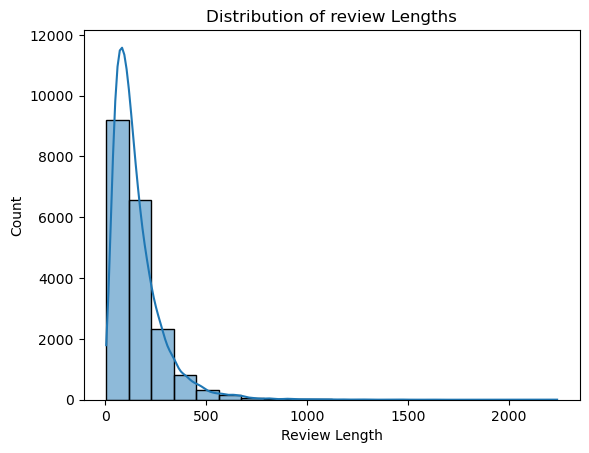

In [95]:
import seaborn as sns
train_data['text_length'] = train_data['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(train_data['text_length'], bins=20, kde=True)
plt.title('Distribution of review Lengths')
plt.xlabel('Review Length')
plt.show()

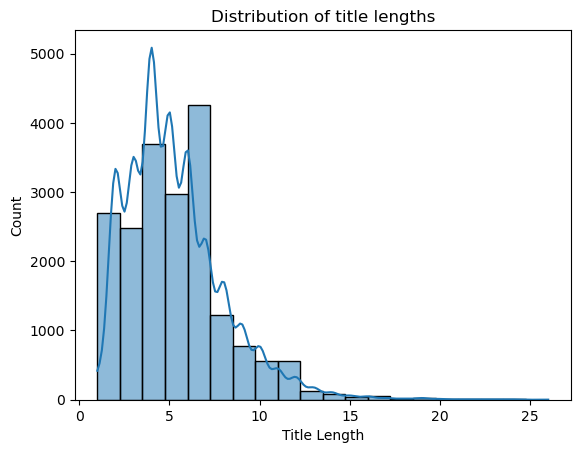

In [96]:
train_data['title_length'] = train_data['clean_title'].apply(lambda x: len(x.split()))
sns.histplot(train_data['title_length'], bins=20, kde=True)
plt.title('Distribution of title lengths')
plt.xlabel('Title Length')
plt.show()

[(5, 7933), (4, 6471), (3, 2671), (2, 1311), (1, 1174)]


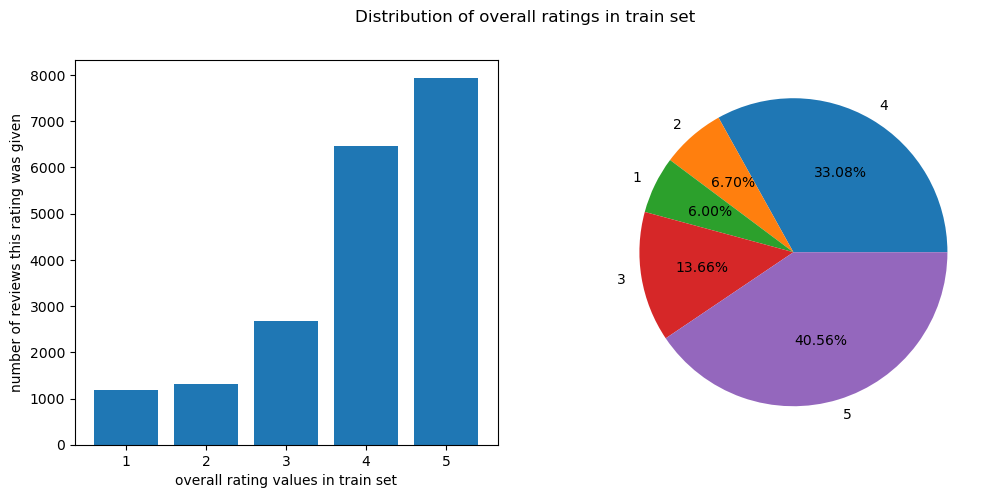

In [97]:
def overall_ratings_plot(data, type):
    ratings_distribution = []
    for i in range(len(data)):
        ratings_distribution.append(int(train_data['ratings'][i]['overall']))
    ratings_freq = Counter(ratings_distribution)
    print(sorted(ratings_freq.items(), key= lambda x:x[0], reverse=True))
    # total = sum(ratings_freq.values())
    # print(total)
    # print(f'{type} set ratings distribution:', ratings_freq)
    # ratios = [(val, round(cnt/total, 3)) for val, cnt in ratings_freq.items()]
    # print(f"percentage of dataset per rating: {sorted(ratios, key= lambda x:x[1], reverse = True)}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Distribution of overall ratings in {type} set')
    axes[0].bar(ratings_freq.keys(), ratings_freq.values())
    axes[0].set_xlabel(f'overall rating values in {type} set')
    axes[0].set_ylabel('number of reviews this rating was given')

    axes[1].pie (ratings_freq.values(), labels= ratings_freq.keys(), autopct='%1.2f%%')

overall_ratings_plot(train_data, 'train')

[(5, 2035), (4, 1565), (3, 683), (2, 335), (1, 278)]


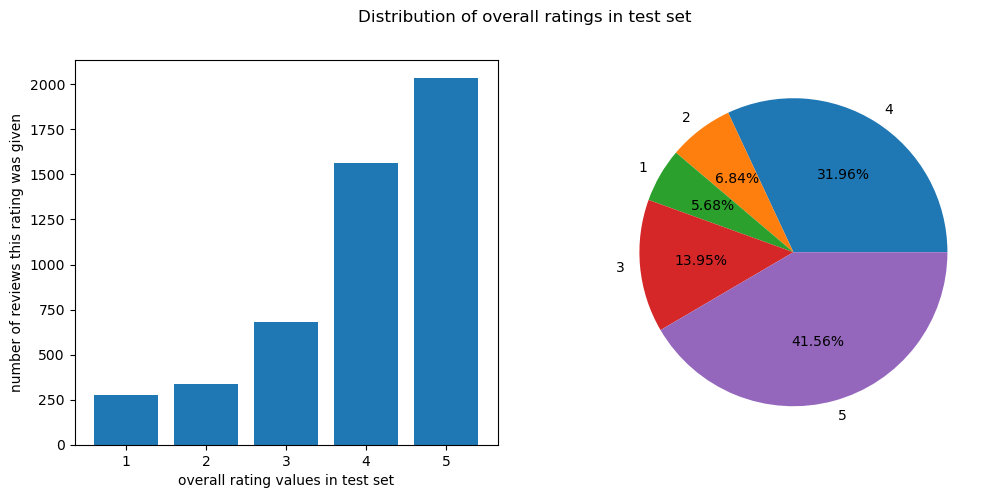

In [98]:
overall_ratings_plot(test_data, 'test')

In [99]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
train_data['stemmed_text'] = train_data['clean_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
train_data['stemmed_text']

0        close to union squar hotel is a bit of a maze ...
1        i had a bad vibe about thi place from the mome...
2        after we receiv our final bill and left the em...
3        step to grand central a veri well situat hotel...
4        thi hotel is locat right in the heart of san f...
                               ...                        
19555    we stay just one night here when visit our son...
19556    spent two night here with spous in conjunct wi...
19557    the room wa fairli larg pretti quiet the bed w...
19558    great start to our stay when we were check in ...
19559    great room comfort bed food is good the locat ...
Name: stemmed_text, Length: 19560, dtype: object

In [100]:
import spacy

nlp = spacy.load('en_core_web_sm')

#Noting: Lemmatization takes a while to run so running through pipe to speed it up (still takes ~2 mins)
def lemmatize(text):
    docs = list(nlp.pipe(text))
    return [' '.join([token.lemma_ for token in doc]) for doc in docs]

train_data['lemmatized_text'] = lemmatize(train_data['clean_text'])
train_data['lemmatized_text']

0        close to Union Square hotel be a bit of a maze...
1        I have a bad vibe about this place from the mo...
2        after we receive our final bill and leave the ...
3        step to Grand Central a very well situated hot...
4        this Hotel be locate right in the heart of San...
                               ...                        
19555    we stay just one night here when visit our son...
19556    spend two night here with spouse in conjunctio...
19557    the room be fairly large pretty quiet the bed ...
19558    great start to our stay when we be check in 2h...
19559    great room comfortable bed food be good the lo...
Name: lemmatized_text, Length: 19560, dtype: object

In [101]:
a1 = train_data['stemmed_text'][4].split()
a2 = train_data['lemmatized_text'][4].split()
a3 = train_data['clean_text'][4].split()

print("Original Word | Stemmed Form | Lemmatized Form")
print("-" * 50)

for orig, stem, lemma in zip(a3, a1, a2):
    if stem != lemma:
        print(f"{orig:<13} | {stem:<12} | {lemma:<12}")


Original Word | Stemmed Form | Lemmatized Form
--------------------------------------------------
This          | thi          | this        
Hotel         | hotel        | Hotel       
is            | is           | be          
located       | locat        | locate      
San           | san          | San         
Francisco     | francisco    | Francisco   
Union         | union        | Union       
Square        | squar        | Square      
is            | is           | be          
Starbucks     | starbuck     | Starbucks   
coffee        | coffe        | coffee      
was           | wa           | be          
definite      | definit      | definite    
plus          | plu          | plus        
Cable         | cabl         | Cable       
service       | servic       | service     
remember      | rememb       | remember    
this          | thi          | this        
was           | wa           | be          
built         | built        | build       
thus          | thu   

using lemmatized text for further textual analysis as stemming can occasionally cut the actual word into its "stem" --> not very useful for model or eda

In [102]:
unique_words = set()
most_frequent_words = defaultdict(int)
for i in range(len(train_data)):
    data = train_data['clean_text'][i].split()
    for w in data:
        unique_words.add(w)
        most_frequent_words[w] += 1

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

most_freq = sorted(most_frequent_words.items(), key=lambda x: x[1], reverse=True)
print(f"most frequent words use in reviews: {most_freq[:10]}") #Notice how all of them are stop words --> dataset needs pruning

number of unique words: 55927
most frequent words use in reviews: [('the', 161469), ('and', 107082), ('a', 87206), ('to', 78626), ('was', 66364), ('I', 49831), ('in', 48038), ('of', 42293), ('The', 40028), ('is', 38589)]


In [103]:
unique_words = set()
all_words = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    for w in data:
        unique_words.add(w)
        all_words.append(w)

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

#Note these are all stop words so should probably prune the dataset for stop words before looking for most common words
fdist = FreqDist(all_words)
fdist.most_common(10)

number of unique words: 55922


[('the', 161469),
 ('and', 107082),
 ('a', 87206),
 ('to', 78626),
 ('was', 66364),
 ('I', 49831),
 ('in', 48038),
 ('of', 42293),
 ('The', 40028),
 ('is', 38589)]

In [104]:
unique_words = set()
all_words = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    for w in data:
        unique_words.add(w)
        all_words.append(w)

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

#Note these are all stop words so should probably prune the dataset for stop words before looking for most common words
fdist = FreqDist(all_words)
fdist.most_common(10)

number of unique words: 48092


[('the', 201664),
 ('be', 166199),
 ('and', 108447),
 ('a', 89093),
 ('to', 79066),
 ('I', 60976),
 ('we', 51277),
 ('in', 49332),
 ('of', 42468),
 ('room', 38978)]

In [105]:
unique_words = set()
most_frequent_words = defaultdict(int)
for i in range(len(train_data)):
    data = train_data['lemmatized_text'][i].split()
    for w in data:
        unique_words.add(w)
        most_frequent_words[w] += 1

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

most_freq = sorted(most_frequent_words.items(), key=lambda x: x[1], reverse=True)
print(f"most frequent words use in reviews: {most_freq[:10]}") #Notice how all of them are stop words --> dataset needs pruning

number of unique words: 48091
most frequent words use in reviews: [('the', 201664), ('be', 166199), ('and', 108447), ('a', 89093), ('to', 79066), ('I', 60976), ('we', 51277), ('in', 49332), ('of', 42468), ('room', 38978)]


In [106]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def most_common_words(N:list):
    most_frequent_actual_words = []

    for n in N:
        if n[0].lower() not in stop_words:
            most_frequent_actual_words.append(n)
        if len(most_frequent_actual_words) == 10:
            break

    return most_frequent_actual_words

most_frequent_actual_words = most_common_words(most_freq)
most_frequent_actual_words

[('room', 38978),
 ('hotel', 36513),
 ('stay', 24075),
 ('great', 13430),
 ('would', 11814),
 ('staff', 11757),
 ('get', 11726),
 ('good', 11565),
 ('night', 10321),
 ('nice', 9578)]

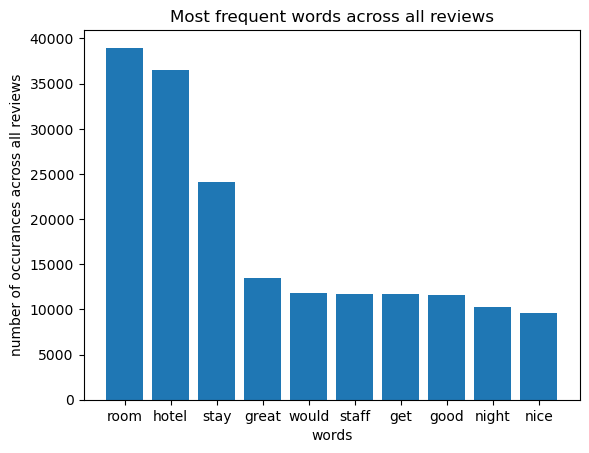

In [107]:
def plot_words(words, title_text, y_axis_text):
    words, counts = zip(*words)
    plt.bar(words, counts)
    plt.xlabel('words')
    plt.ylabel(y_axis_text)
    plt.title(title_text)

plot_words(most_frequent_actual_words,'Most frequent words across all reviews', 'number of occurances across all reviews')

In [108]:
def most_common_words_sentiment(N:list):
    negative_words = []
    positive_words = []
    for i in range(len(N)):
        data = word_tokenize(N['lemmatized_text'][i])
        rating = int(N['ratings'][i]['overall'])
        for w in data:
            if w.lower() in stop_words: continue
            if rating >= 2.5:
                positive_words.append(w)
            else:
                negative_words.append(w)
    
    return Counter(positive_words), Counter(negative_words)

positive_review_words, negative_review_words = most_common_words_sentiment(train_data)

print("Most common words in positive reviews: ")
positive_review_words.most_common(10)

Most common words in positive reviews: 


[('room', 31879),
 ('hotel', 31152),
 ('stay', 20771),
 ('great', 12878),
 ('staff', 10523),
 ('good', 10464),
 ('would', 9552),
 ('get', 9357),
 ('nice', 8804),
 ('night', 8392)]

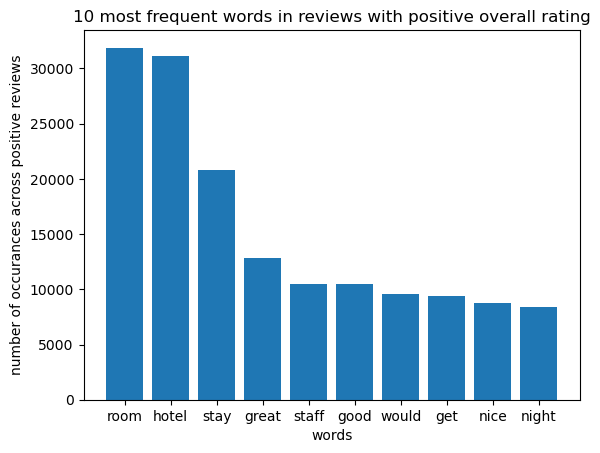

In [109]:
plot_words(positive_review_words.most_common(10),'10 most frequent words in reviews with positive overall rating', 'number of occurances across positive reviews')

In [110]:
print("Most common words in negative reviews:")
negative_review_words.most_common(10)

Most common words in negative reviews:


[('room', 7099),
 ('hotel', 5361),
 ('stay', 3304),
 ('get', 2369),
 ('would', 2262),
 ('night', 1929),
 ('one', 1775),
 ('go', 1720),
 ('say', 1354),
 ('could', 1329)]

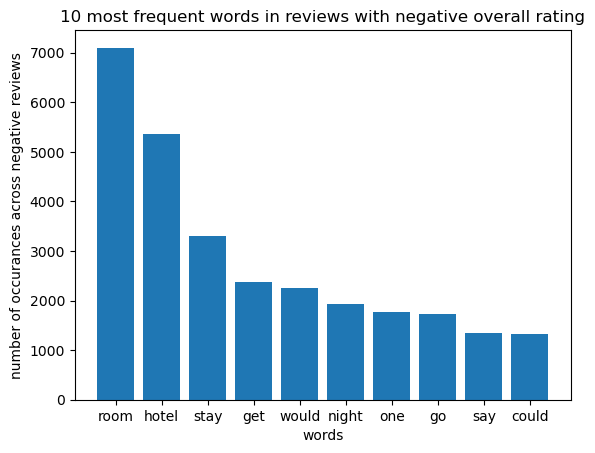

In [111]:
plot_words(negative_review_words.most_common(10),'10 most frequent words in reviews with negative overall rating', 'number of occurances across negative reviews')

In [112]:
from nltk import ngrams
n = 3
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_grams_list = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    n_grams = generate_ngrams(data, n)
    for gram in n_grams:
        n_grams_list.append(gram)

n_gram_freq = Counter(n_grams_list)

print(f"Distribution of {n}-grams:")
for ngram, count in n_gram_freq.most_common(10):
    print(f"{ngram}: {count}")

Distribution of 3-grams:
the front desk: 2426
The room was: 2412
in the room: 1847
of the hotel: 1751
The hotel is: 1687
stay here again: 1402
at this hotel: 1333
stayed at the: 1330
the room was: 1297
one of the: 1249


In [113]:
n = 3
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_grams_list = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    n_grams = generate_ngrams(data, n)
    for gram in n_grams:
        n_grams_list.append(gram)

n_gram_freq = Counter(n_grams_list)

print(f"Distribution of {n}-grams:")
for ngram, count in n_gram_freq.most_common(10):
    print(f"{ngram}: {count}")

Distribution of 3-grams:
the room be: 7168
the hotel be: 4508
the staff be: 3460
the front desk: 3030
stay at the: 2974
there be a: 2873
I do not: 2264
in the room: 2199
it be a: 2125
the location be: 1947


Not very useful. What if we look at the most common tri grams for both "positive" and negative reviews?


In [114]:
positive_ngrams = []
negative_ngrams = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    n_grams = generate_ngrams(data, n)
    rating = int(train_data['ratings'][i]['overall'])
    if rating >= 2.5:
        for gram in n_grams:
            positive_ngrams.append(gram)
    else:
        for gram in n_grams:
            negative_ngrams.append(gram)

positive_ngrams_freq = Counter(positive_ngrams)
negative_ngrams_freq = Counter(negative_ngrams)

print(f"Most common {n}-grams for positive rating reviews:")
for ngram, count in positive_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")
print('\n')
print(f"Most common {n}-grams for negative rating reviews:")
for ngram, count in negative_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")


Most common 3-grams for positive rating reviews:
The room was: 2184
the front desk: 1726
The hotel is: 1581
of the hotel: 1524
in the room: 1445
stay here again: 1292
stayed at the: 1198
at this hotel: 1112
one of the: 1093
the room was: 1080


Most common 3-grams for negative rating reviews:
the front desk: 700
in the room: 402
The room was: 228
of the hotel: 227
I had to: 226
at this hotel: 221
the room was: 217
to the front: 174
we had to: 167
at the hotel: 163


In [115]:
positive_ngrams = []
negative_ngrams = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    n_grams = generate_ngrams(data, n)
    rating = int(train_data['ratings'][i]['overall'])
    if rating >= 2.5:
        for gram in n_grams:
            positive_ngrams.append(gram)
    else:
        for gram in n_grams:
            negative_ngrams.append(gram)

positive_ngrams_freq = Counter(positive_ngrams)
negative_ngrams_freq = Counter(negative_ngrams)

print(f"Most common {n}-grams for positive rating reviews:")
for ngram, count in positive_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")
print('\n')
print(f"Most common {n}-grams for negative rating reviews:")
for ngram, count in negative_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")


Most common 3-grams for positive rating reviews:
the room be: 6326
the hotel be: 4073
the staff be: 3226
stay at the: 2655
there be a: 2483
the front desk: 2233
it be a: 1897
the location be: 1799
I do not: 1764
in the room: 1730


Most common 3-grams for negative rating reviews:
the room be: 842
the front desk: 797
I do not: 500
in the room: 469
the hotel be: 435
there be no: 418
there be a: 390
stay at the: 319
this hotel be: 298
I have to: 287


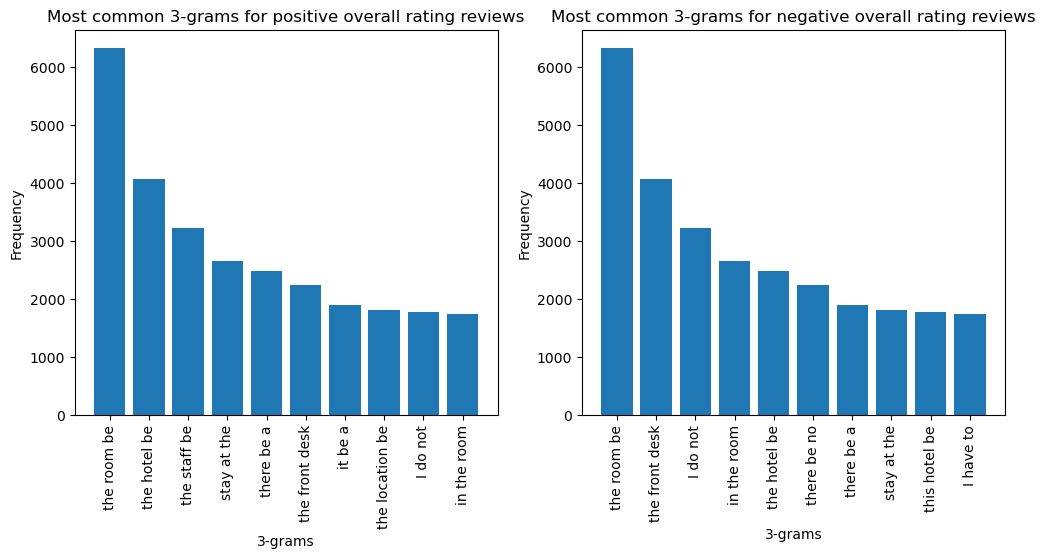

In [116]:
labels_pos, values_pos = zip(*positive_ngrams_freq.most_common(10))
labels_neg, values_neg = zip(*negative_ngrams_freq.most_common(10))
indexes = range(len(labels_pos))

lables = [labels_pos, labels_neg]
values = [values_pos, values_pos]

titles = [f"Most common {n}-grams for positive overall rating reviews", f"Most common {n}-grams for negative overall rating reviews"]
def multi_graph(indexes, labels, values, count, titles):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(count):
        axes[i].bar(indexes, values[i])
        axes[i].set_xlabel(f'{n}-grams')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xticks(indexes, labels[i], rotation='vertical')
        axes[i].set_title(titles[i])

multi_graph(indexes, lables, values, 2, titles)

In [117]:
titles = train_data['clean_title']
title_words = []
for n in train_data['clean_title']:
    title = word_tokenize(n)
    for w in title:
        title_words.append(w.lower())

print(Counter(title_words).most_common(10))

[('great', 5631), ('hotel', 4250), ('location', 3816), ('the', 3162), ('a', 2808), ('and', 2579), ('stay', 2378), ('in', 1938), ('for', 1891), ('good', 1842)]


In [118]:
title_words_ns = []
for n in train_data['clean_title']:
    title = word_tokenize(n)
    for w in title:
        if w.lower() not in stop_words:
            title_words_ns.append(w.lower())
            
print(Counter(title_words_ns).most_common(10))

[('great', 5631), ('hotel', 4250), ('location', 3816), ('stay', 2378), ('good', 1842), ('nice', 1361), ('service', 1299), ('staff', 1017), ('place', 1005), ('excellent', 660)]


Based off all these experiments, it becomes apparent that some additional changes must be made to the data before being fed into a machine learning model. Given the consistant requirement of lowercasing the words for both the title and the text, all the text should be normalised through lowercasing. Though this might remove some of the "textual emotion" conveyed in some of the reviews as capital letters could indicate both excitement and anger. But also these are not terribly useful considering how similar the good and the bad reviews seem to be in terms of word similar. So rather than frequency or even n-gram maybe we need to look deeper

### 3. Selection and training Machine Learning models

In [119]:
train_data['lemmatized_text'] = train_data['lemmatized_text'].apply(lambda x: x.lower())
train_data['clean_title'] = train_data['clean_title'].apply(lambda x: x.lower())

In [120]:
train_data['clean_title'] = lemmatize(train_data['clean_title'])

In [121]:
def get_overall(ratings):
    try:
        return int(ratings.get('overall',None))
    except(AttributeError, TypeError):
        return None

train_data['overall'] = train_data['ratings'].apply(get_overall)
train_data['overall']

0        4
1        2
2        1
3        4
4        3
        ..
19555    4
19556    3
19557    5
19558    4
19559    5
Name: overall, Length: 19560, dtype: int64

In [122]:
lem_train_data = train_data[['overall', 'clean_title','lemmatized_text']]
stem_train_data =  train_data[['overall', 'clean_title','stemmed_text']]

In [123]:
lem_train_data

,overall,clean_title,lemmatized_text
0,4,great location and service,close to union square hotel be a bit of a maze...
1,2,I will never go back here again,i have a bad vibe about this place from the mo...
2,1,rip off our visa card after departure,after we receive our final bill and leave the ...
3,4,a great location,step to grand central a very well situated hot...
4,3,its all about the location,this hotel be locate right in the heart of san...
...,...,...,...
19555,4,pleasant stay with good location,we stay just one night here when visit our son...
19556,3,hit or miss some thing need attention,spend two night here with spouse in conjunctio...
19557,5,good breakfast,the room be fairly large pretty quiet the bed ...
19558,4,deserve a high rating,great start to our stay when we be check in 2h...


In [132]:
lem_train_data.loc[:, 'lemmatized_text'] = lem_train_data['clean_title'] + ' ' + lem_train_data['lemmatized_text']

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, mean_absolute_error, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(lem_train_data["lemmatized_text"], 
                                                    lem_train_data["overall"], 
                                                    test_size=0.3, 
                                                    random_state=42)
print(len(X_train), len(X_test))

13692 5868


In [140]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
# vectorizer = CountVectorizer(lowercase=True, token_pattern='[a-zA-Z0-9@#$%_]{2,}', \
#                                  max_features=None)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Multinomial Naive Bayes:
Accuracy: 0.5913
F1 score: 0.5593
Mean Absolute Error: 0.5061
              precision    recall  f1-score   support

           1       0.74      0.40      0.52       337
           2       0.32      0.02      0.04       370
           3       0.34      0.18      0.24       825
           4       0.50      0.64      0.56      1963
           5       0.71      0.81      0.75      2373

    accuracy                           0.59      5868
   macro avg       0.52      0.41      0.42      5868
weighted avg       0.56      0.59      0.56      5868



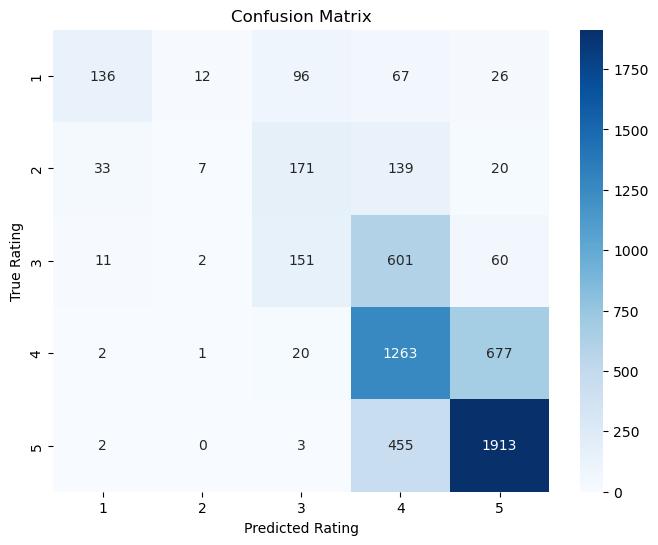

In [141]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)

y_pred_mnb = mnb.predict(X_test_vec)
mae = mean_absolute_error(y_test, y_pred_mnb)
acc = accuracy_score(y_test, y_pred_mnb)
weighted_f1 = f1_score(y_test, y_pred_mnb, average='weighted')

print("Multinomial Naive Bayes:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_mnb))

con_mat = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


Cross-Validation Scores: [0.63369121 0.62832311 0.63752556 0.62960123 0.62576687]
Mean Stratified CV Score: 0.6310 (±0.0042)
SVM:
Accuracy: 0.6244
F1 score: 0.6138
Mean Absolute Error: 0.4371
              precision    recall  f1-score   support

           1       0.63      0.68      0.65       337
           2       0.45      0.25      0.32       370
           3       0.51      0.38      0.44       825
           4       0.56      0.57      0.57      1963
           5       0.71      0.80      0.75      2373

    accuracy                           0.62      5868
   macro avg       0.57      0.54      0.55      5868
weighted avg       0.61      0.62      0.61      5868



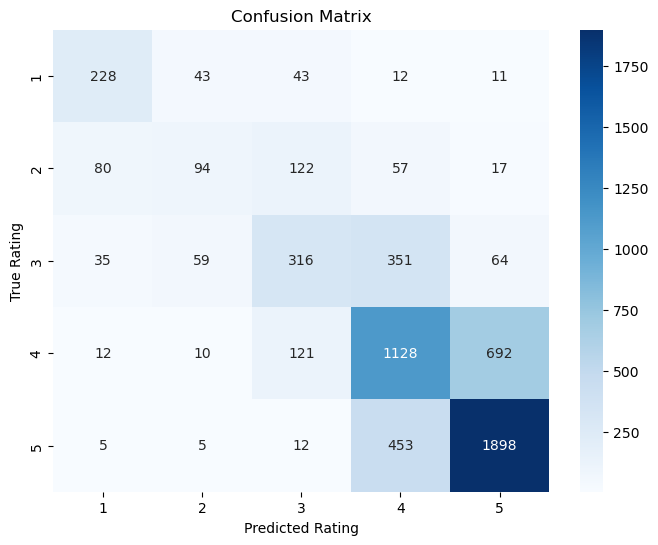

In [142]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
    ('classifier', LinearSVC(penalty='l1', dual=False, C=1))
])

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_cv_scores = cross_val_score(pipeline, lem_train_data["lemmatized_text"], 
                                       lem_train_data["overall"], 
                                       cv=stratified_kfold, scoring='accuracy')

print(f"Cross-Validation Scores: {stratified_cv_scores}")
print(f"Mean Stratified CV Score: {np.mean(stratified_cv_scores):.4f} (±{np.std(stratified_cv_scores):.4f})")

pipeline.fit(X_train, y_train)

y_pred_svm = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_svm)
acc = accuracy_score(y_test, y_pred_svm)
weighted_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print("SVM:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_svm))

con_mat = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('classifier', LogisticRegression(max_iter=1000))
])

#Stratified K-Fold (better if "overall" ratings are imbalanced)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_cv_scores = cross_val_score(pipeline, lem_train_data["lemmatized_text"], 
                                       lem_train_data["overall"], 
                                       cv=stratified_kfold, scoring='accuracy')

print(f"Cross-Validation Scores (Stratified): {stratified_cv_scores}")
print(f"Mean Stratified CV Score: {np.mean(stratified_cv_scores):.4f} (±{np.std(stratified_cv_scores):.4f})")

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1 score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Cross-Validation Scores (Stratified): [0.63241309 0.61247444 0.6293456  0.61349693 0.62346626]
Mean Stratified CV Score: 0.6222 (±0.0081)

Test Set Evaluation:
Accuracy: 0.6242
f1 score: 0.6148

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.59      0.63       337
           2       0.44      0.24      0.31       370
           3       0.50      0.40      0.45       825
           4       0.56      0.59      0.58      1963
           5       0.71      0.79      0.75      2373

    accuracy                           0.62      5868
   macro avg       0.58      0.52      0.54      5868
weighted avg       0.61      0.62      0.61      5868



Random Forest:
Accuracy: 0.5075
F1 score: 0.4321
Mean Absolute Error: 0.7491
              precision    recall  f1-score   support

           1       0.92      0.10      0.18       337
           2       0.50      0.01      0.01       370
           3       0.32      0.01      0.01       825
           4       0.41      0.45      0.43      1963
           5       0.56      0.86      0.68      2373

    accuracy                           0.51      5868
   macro avg       0.54      0.29      0.26      5868
weighted avg       0.49      0.51      0.43      5868



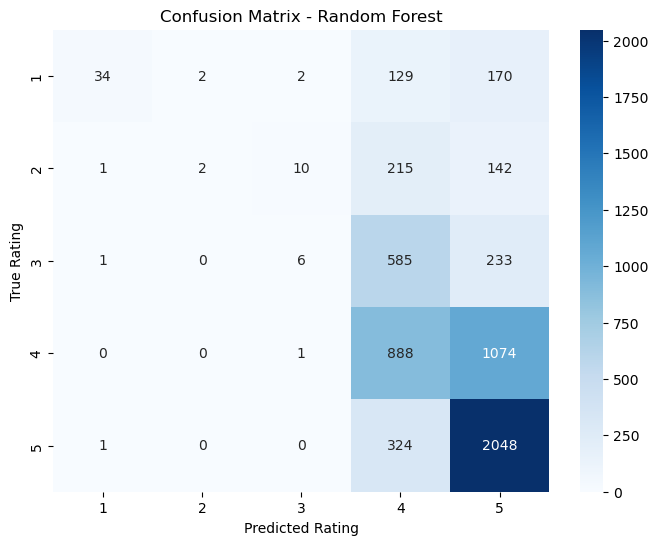

In [144]:
from sklearn.ensemble import RandomForestClassifier
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
    ('classifier', RandomForestClassifier(
        n_estimators=100,     
        max_depth=None,       
        min_samples_split=2,  
        random_state=42       
    ))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
acc = accuracy_score(y_test, y_pred_rf)
weighted_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_rf))

con_mat = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=range(1, 6),
           yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [145]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# !python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_md')

X_train, X_test, y_train, y_test = train_test_split(
    lem_train_data["lemmatized_text"], 
    lem_train_data["overall"], 
    test_size=0.3, 
    random_state=42
)
print(len(X_train), len(X_test))

13692 5868


In [146]:
import spacy
# !python -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md') 

def document_vector_spacy(doc, nlp_model):
    doc = nlp_model(doc)
    return doc.vector

X_train_vectors = np.array([document_vector_spacy(doc, nlp) for doc in X_train])
X_test_vectors = np.array([document_vector_spacy(doc, nlp) for doc in X_test])

svm = SVC(kernel="linear", C=1)
svm.fit(X_train_vectors, y_train)

y_pred_svm = svm.predict(X_test_vectors)

mae = mean_absolute_error(y_test, y_pred_svm)
acc = accuracy_score(y_test, y_pred_svm)
weighted_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print("SVM with word vectors:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_svm))


SVM with word vectors:
Accuracy: 0.5395
F1 score: 0.5057
Mean Absolute Error: 0.5941
              precision    recall  f1-score   support

           1       0.48      0.53      0.51       337
           2       0.32      0.16      0.21       370
           3       0.42      0.06      0.10       825
           4       0.45      0.60      0.51      1963
           5       0.65      0.72      0.69      2373

    accuracy                           0.54      5868
   macro avg       0.47      0.41      0.40      5868
weighted avg       0.52      0.54      0.51      5868



Random Forest with word vectors:
Accuracy: 0.5056
F1 score: 0.4714
Mean Absolute Error: 0.6801
              precision    recall  f1-score   support

           1       0.48      0.41      0.44       337
           2       0.33      0.09      0.15       370
           3       0.33      0.10      0.16       825
           4       0.44      0.46      0.45      1963
           5       0.57      0.76      0.65      2373

    accuracy                           0.51      5868
   macro avg       0.43      0.37      0.37      5868
weighted avg       0.47      0.51      0.47      5868



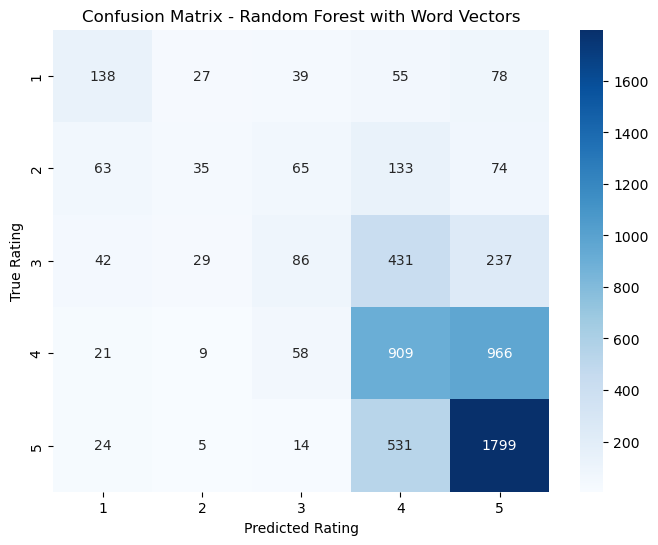

In [147]:
from sklearn.base import BaseEstimator, TransformerMixin

class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model='en_core_web_md'):
        self.model = model
        self.nlp = spacy.load(model)
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([self.nlp(doc).vector for doc in X])

pipeline_rf_vectors = Pipeline([
    ('word_vectors', SpacyVectorTransformer(model='en_core_web_md')),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ))
])

pipeline_rf_vectors.fit(X_train, y_train)

y_pred_rf = pipeline_rf_vectors.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
acc = accuracy_score(y_test, y_pred_rf)
weighted_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest with word vectors:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_rf))

con_mat = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=range(1, 6),
           yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix - Random Forest with Word Vectors')
plt.show()

### 4. Experiment with VADER sentiment lexicon

In [151]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

sentiment = SentimentIntensityAnalyzer()

def sentiment_scores(text):
    score = sentiment.polarity_scores(text)
    return score['compound']

lem_train_data.loc[:, 'vader_score'] = lem_train_data['lemmatized_text'].apply(sentiment_scores)
lem_train_data


/tmp/ipykernel_144440/1105961701.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lem_train_data.loc[:, 'vader_score'] = lem_train_data['lemmatized_text'].apply(sentiment_scores)


,overall,clean_title,lemmatized_text,vader_score
0,4,great location and service,great location and service great location and ...,0.9230
1,2,I will never go back here again,I will never go back here again I will never g...,0.9418
2,1,rip off our visa card after departure,rip off our visa card after departure rip off ...,0.4215
3,4,a great location,a great location a great location step to gran...,0.9273
4,3,its all about the location,its all about the location its all about the l...,0.9955
...,...,...,...,...
19555,4,pleasant stay with good location,pleasant stay with good location pleasant stay...,0.9752
19556,3,hit or miss some thing need attention,hit or miss some thing need attention hit or m...,-0.9035
19557,5,good breakfast,good breakfast good breakfast the room be fair...,0.9136
19558,4,deserve a high rating,deserve a high rating deserve a high rating gr...,0.9682


In [155]:
def vader_classification(score):
    if score >= 0.7:
        return 5
    elif score > 0.3:
        return 4
    elif score > -0.3:
        return 3
    elif score >= -0.7:
        return 2
    else:
        return 1
    
lem_train_data.loc[:, 'vader_rating'] = lem_train_data['vader_score'].apply(vader_classification)
lem_train_data['vader_rating']
lem_train_data.loc[:, 'rating_discrepancy'] = abs(lem_train_data['overall'] - lem_train_data['vader_rating'])
lem_train_data

,overall,clean_title,lemmatized_text,vader_score,vader_rating,rating_discrepancy
0,4,great location and service,great location and service great location and ...,0.9230,5,1
1,2,I will never go back here again,I will never go back here again I will never g...,0.9418,5,3
2,1,rip off our visa card after departure,rip off our visa card after departure rip off ...,0.4215,4,3
3,4,a great location,a great location a great location step to gran...,0.9273,5,1
4,3,its all about the location,its all about the location its all about the l...,0.9955,5,2
...,...,...,...,...,...,...
19555,4,pleasant stay with good location,pleasant stay with good location pleasant stay...,0.9752,5,1
19556,3,hit or miss some thing need attention,hit or miss some thing need attention hit or m...,-0.9035,1,2
19557,5,good breakfast,good breakfast good breakfast the room be fair...,0.9136,5,0
19558,4,deserve a high rating,deserve a high rating deserve a high rating gr...,0.9682,5,1


In [156]:
mean_discrepancy = lem_train_data['rating_discrepancy'].mean()
print(f"The average discrepancy between vader sentiment rating based on text and ground truth rating given by customer is: {mean_discrepancy:.4f}")

The average discrepancy between vader sentiment rating based on text and ground truth rating given by customer is: 0.7945


accuracy: 0.4500
precision: 0.3618
recall: 0.4500
f1_weighted: 0.3255
              precision    recall  f1-score   support

           1       0.54      0.45      0.49      1174
           2       0.28      0.10      0.15      1311
           3       0.30      0.06      0.10      2671
           4       0.25      0.03      0.05      6471
           5       0.46      0.98      0.63      7933

    accuracy                           0.45     19560
   macro avg       0.37      0.32      0.28     19560
weighted avg       0.36      0.45      0.33     19560



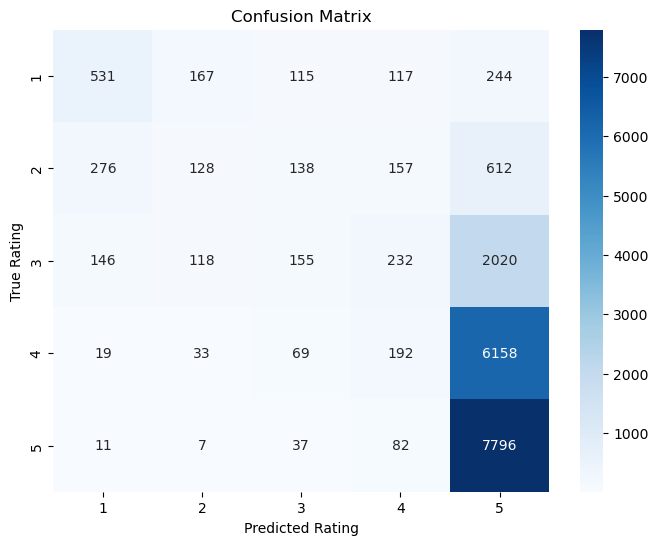

In [157]:
y_true, y_pred = lem_train_data['overall'], lem_train_data['vader_rating']

accuracy = accuracy_score(y_true, y_pred)
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f'accuracy: {accuracy:.4f}')
print(f'precision: {precision_weighted:.4f}')
print(f'recall: {recall_weighted:.4f}')
print(f'f1_weighted: {f1_weighted:.4f}')

print(classification_report(y_true, y_pred))

con_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

### 5. Final testing on test set and discussion of results

### 6. Propose a method to predict aspects 

***(COMP SCI 7417 and COMP SCI 7717 only)***

### 7. Reflection on the ***Product*** development.

### 9. References

### Appendix